In [1]:
import numpy as np
import pandas as pd
import os 
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from svi import SVI
import models as m
import datasets as d

# Load and Prepare Data

In [2]:
data = dd.load("sequenced_data_for_VAE_lenght-160_stride-10.h5")

In [3]:
X,y = data["X"], data["y"]

In [4]:
#torch.save(X, "X_sequenced_data_for_VAE_lenght-160_stride-10.pt")

In [5]:
#torch.save(y, "y_sequenced_data_for_VAE_lenght-160_stride-10.pt")

In [4]:
X.shape

torch.Size([83680, 160])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=300, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=300, shuffle=True)

# Model setup

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.cuda.get_device_name()

'GeForce GTX 1070'

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
model_name = "DeepConvVAE_ELU_NLL_100ep_lr-1e-3_bs-300"

In [13]:
deepmodel = m.DeepConvVAE_ELU(original_dim=160, latent_dim=15) #m.DeepConvVAE_ReLU(original_dim=160, latent_dim=15)
svi = SVI(
        vae_model=deepmodel,
        optimizer=torch.optim.Adam(deepmodel.parameters(), lr=1e-3),
        loss_function="GaussianNLL",
        verbose=True
        )

cuda:0


In [14]:
loss_hist = svi(epochs=100, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/100], average_loss:28.3917, validation_loss:-57.6121
Epoch [2/100], average_loss:-86.4566, validation_loss:-105.3434
Epoch [3/100], average_loss:-116.2266, validation_loss:-123.5212
Epoch [4/100], average_loss:-133.2399, validation_loss:-138.8700
Epoch [5/100], average_loss:-139.3681, validation_loss:-124.9823
Epoch [6/100], average_loss:-147.8165, validation_loss:-148.3826
Epoch [7/100], average_loss:-150.0565, validation_loss:-152.1688
Epoch [8/100], average_loss:-153.6745, validation_loss:-150.3954
Epoch [9/100], average_loss:-155.9458, validation_loss:-156.0156
Epoch [10/100], average_loss:-159.2791, validation_loss:-157.2308
Epoch [11/100], average_loss:-159.2549, validation_loss:-162.9121
Epoch [12/100], average_loss:-164.0657, validation_loss:-164.3998
Epoch [13/100], average_loss:-165.4535, validation_loss:-151.0345
Epoch [14/100], average_loss:-171.8053, validation_loss:-168.0706
Epoch [15/100], average_loss:-172.5975, validation_loss:-178.3624
Epoch [16/100], average

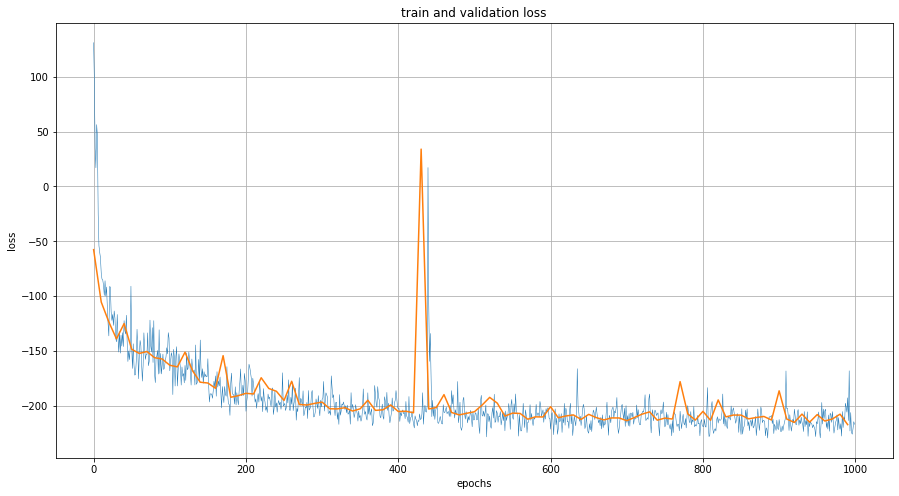

In [28]:
plt.figure(figsize=(15,8))
plt.title("train and validation loss")
epoch_axis = np.arange(len(svi.loss_history["train"]))
plt.plot(epoch_axis, np.array(svi.loss_history["train"]), lw=0.5) #np.arange(len(svi.loss_history["validation"]))*10
plt.plot(np.arange(len(svi.loss_history["validation"]))*10, svi.loss_history["validation"])
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [18]:
torch.save(svi.model, f"VAE_saves_and_logs/{model_name}.pt")
torch.save(svi.optimizer, f"VAE_saves_and_logs/{model_name}_optimizer.pt")
dd.save(f"VAE_saves_and_logs/{model_name}_loss_history.h5", svi.loss_history)

# Evaluation

cuda:0


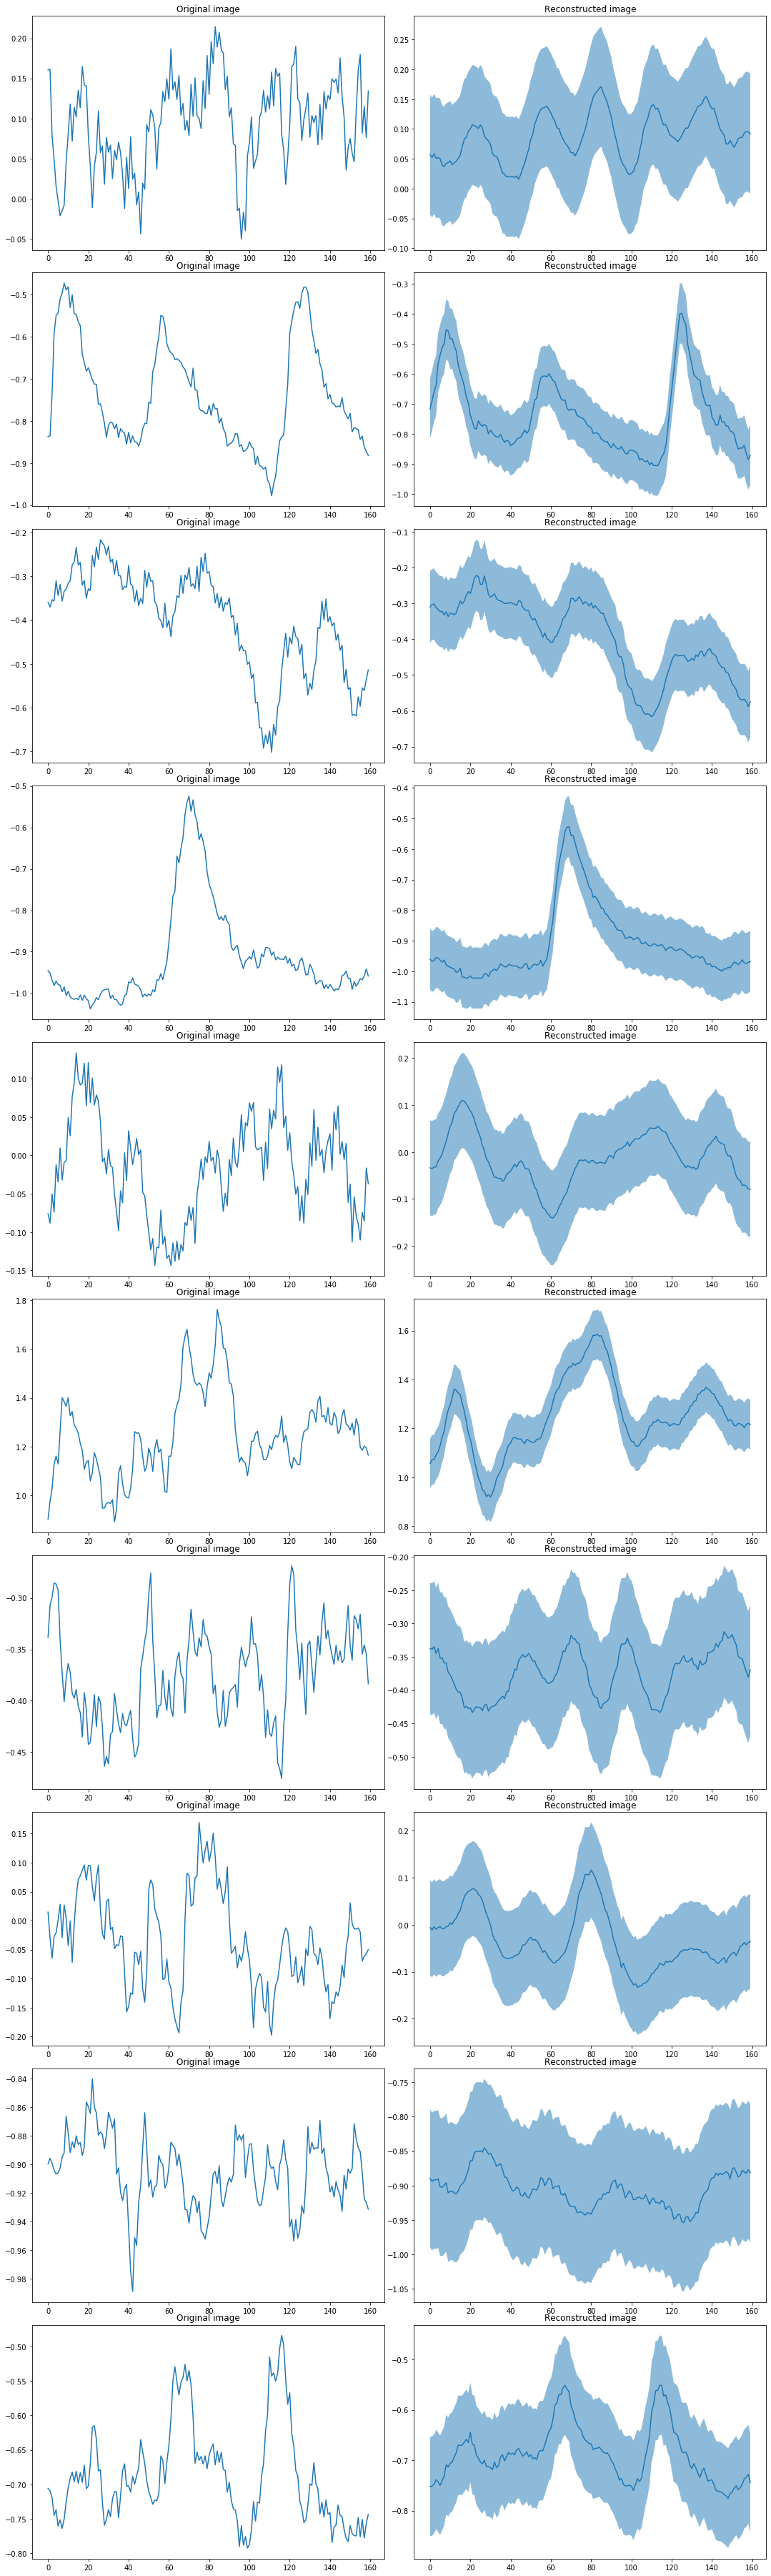

In [19]:
print(device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

# Load Model

In [20]:
mod = torch.load(f"VAE_saves_and_logs/{model_name}.pt")

In [21]:
mod.eval()

DeepConvVAE_ELU(
  (encoder): Sequential(
    (0): Reshape()
    (1): Conv1d(1, 16, kernel_size=(6,), stride=(2,))
    (2): ELU(alpha=1.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(2,))
    (4): ELU(alpha=1.0)
    (5): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
    (6): ELU(alpha=1.0)
    (7): Flatten()
    (8): VariationalLayer(
      (mu): Linear(in_features=1152, out_features=15, bias=True)
      (rho): Linear(in_features=1152, out_features=15, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=1152, bias=True)
    (1): ELU(alpha=1.0)
    (2): Reshape()
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,))
    (4): ELU(alpha=1.0)
    (5): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,))
    (6): ELU(alpha=1.0)
    (7): ConvTransposeDecoderOutput(
      (mu): ConvTranspose1d(16, 1, kernel_size=(6,), stride=(2,))
      (rho): Linear(in_features=1248, out_features=1, bias

In [23]:
z, mu, sigma = mod.encoder(X.to(device))

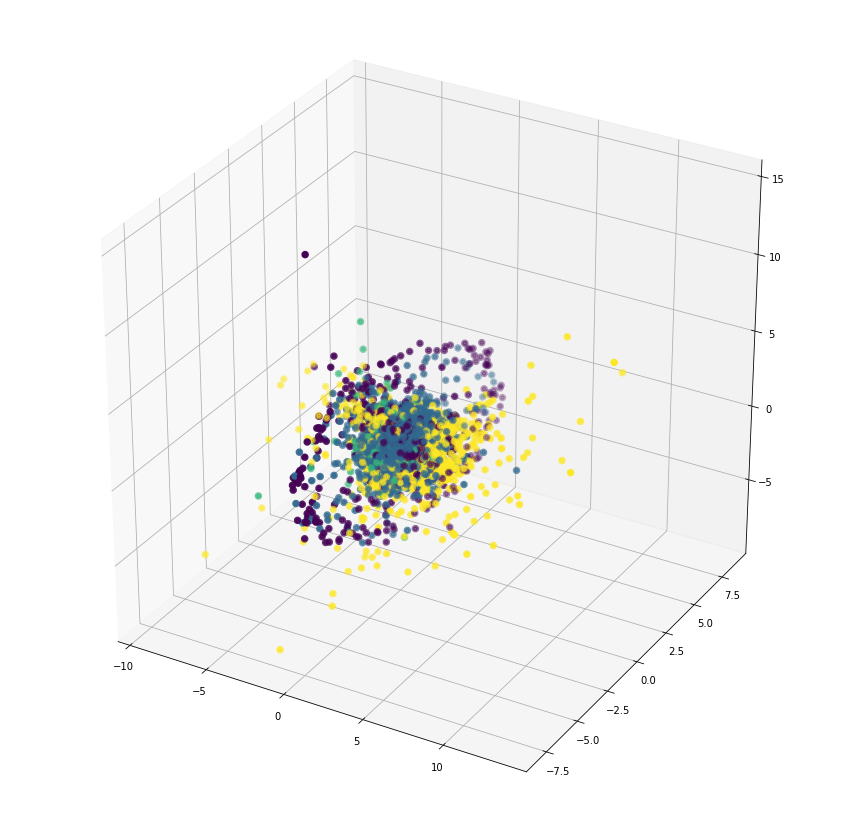

In [24]:
X_1, cl = test.X, test.y
Z_hat, mu, sigma = mod.encoder(X_1.to(device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

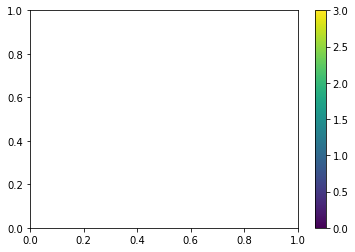

In [25]:
# když přidám colorbar k obrázku tak se nehezky deformuje, tak je tady zvlášť
plt.colorbar(sc, shrink=1)

In [ ]:
test.y